In [1]:
import numpy as np
import cv2
import os
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

def load_images(folderName):

    images = []
    categories = []
    
    for filename in os.listdir(folderName):
        img = cv2.imread(os.path.join(folderName, filename))
        
        if img is not None:
            image = cv2.resize(img, (256,256))
            image = image.astype('uint8')
            images.append(image)
            
            if folderName[14:] == "QUERY_IMAGES":
                ctg = filename.split("_")
                categories.append(ctg[0])
                
            else:
                categories.append(folderName[14:])
            
    return images, categories

In [2]:
def dataset_matrix(images):
    
    for i in range(len(images)):
        
        images[i] = cv2.cvtColor(images[i], cv2.COLOR_BGR2GRAY)
        images[i] = cv2.resize(images[i], (65536,1))
    
    matrix = np.block([[images[0]], [images[1]]])

    for i in range(2, len(images)):
        matrix = np.block([[matrix], [images[i]]])

    matrix = matrix.T
    return matrix

In [3]:
class PCA:

    def __init__(self, dataset_matrix, n_components):
        self.M = dataset_matrix
        self.n = n_components
        print("Dataset matrix shape:", self.M.shape)

    def mean_vector(self):

        mean_vector = []
        for i in self.M.T:
            mean_vector.append(i.mean())

        mean_vector = np.array(mean_vector)
        mean_vector.resize(1, mean_vector.shape[0])
        print("Mean vector shape:", mean_vector.shape)
        return mean_vector

    def normalized_matrix(self):

        D = self.M - self.mean_vector()  # D = normalized matrix
        return D

    def covariance_matrix(self):

        D = self.normalized_matrix()
        covariance_matrix = np.dot(D.T, D)
        print("Covariance matrix shape:", covariance_matrix.shape)
        return covariance_matrix

    def eigen_vector(self):

        eigenValues, eigenVectors = np.linalg.eig(self.covariance_matrix())
        idx = eigenValues.argsort()[::-1]
        V = eigenVectors[idx]
        V = V[:self.n]  # choose first n eigenvectors
        return V

    def feature_matrix(self):

        D = self.normalized_matrix()
        temp_matrix = np.dot(self.eigen_vector(), D.T)
        feature_matrix = np.dot(temp_matrix, D)
        print("PCA feature matrix shape:", feature_matrix.shape)
        return feature_matrix

    def plot(self):

        x_axis, y_axis, z_axis = [], [], []
        feature_matrix = self.feature_matrix()

        for i in range(feature_matrix.shape[1]):
            x_axis.append(feature_matrix[0][i])
            if self.n > 1:
                y_axis.append(feature_matrix[1][i])
            if self.n > 2:
                z_axis.append(feature_matrix[2][i])

        fig = plt.figure()

        if self.n == 1:
            ax = fig.add_subplot()
            ax.set_title('1 Dimension')
            ax.scatter(x_axis, np.zeros_like(x_axis), c='red', marker='o')

        elif self.n == 2:
            ax = fig.add_subplot()
            ax.set_title('2 Dimension')
            ax.scatter(x_axis, y_axis, c='orange', marker='o')

        elif self.n == 3:
            ax = fig.add_subplot(111, projection='3d')
            ax.set_title('3 Dimension')
            ax.scatter(x_axis, y_axis, z_axis, c='purple', marker='o')

        plt.show()

Dataset matrix shape: (65536, 11)
Mean vector shape: (1, 11)
Mean vector shape: (1, 11)
Covariance matrix shape: (11, 11)
PCA feature matrix shape: (3, 11)


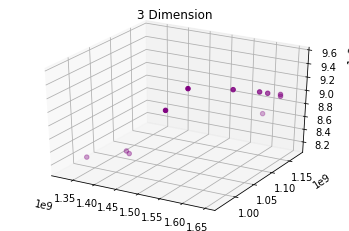

Dataset matrix shape: (65536, 11)
Mean vector shape: (1, 11)
Mean vector shape: (1, 11)
Covariance matrix shape: (11, 11)
PCA feature matrix shape: (2, 11)


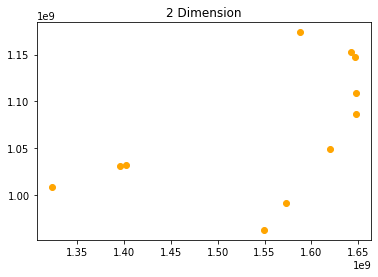

Dataset matrix shape: (65536, 11)
Mean vector shape: (1, 11)
Mean vector shape: (1, 11)
Covariance matrix shape: (11, 11)
PCA feature matrix shape: (1, 11)


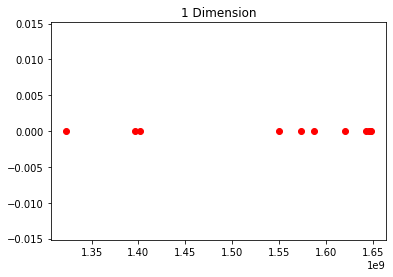

In [4]:
images, names = load_images("Part1-dataset")
M = dataset_matrix(images)

for n in range(3, 0, -1):
    features = PCA(M, n)
    features.plot()

## PART-2

In [5]:
images, image_matrix, categories = [], [], []

directories = os.listdir('Part2-dataset')
for i in directories:
    img, ctg = load_images("Part2-dataset/"+i) 
    images.append(img)
    image_matrix += img
    categories += ctg
    
all_images = image_matrix.copy()

In [6]:
def histogram_features(images):
    
    feature_list = []
    for i in range(len(images)):
        for j in range(len(images[i])):
            img = images[i][j]
            blue_hist = cv2.calcHist([img],[0],None,[33],[0,256])
            red_hist = cv2.calcHist([img],[1],None,[33],[0,256])
            green_hist = cv2.calcHist([img],[2],None,[33],[0,256])
            rgb_hist = np.concatenate((blue_hist, red_hist, green_hist), axis=None)
            feature_list.append(rgb_hist)
    feature_list = np.array(feature_list)
    
    return feature_list

In [7]:
def PCA_and_histogram_features(image_matrix, images, n):
    
    M = dataset_matrix(image_matrix)
    pca = PCA(M, n)
    pca_features = pca.feature_matrix().T
    
    hist_features = histogram_features(images)
    all_features = np.concatenate((hist_features, pca_features), axis=1)
    print("All features matrix shape:", all_features.shape)
    return all_features

In [8]:
all_features = PCA_and_histogram_features(image_matrix, images, 100)

Dataset matrix shape: (65536, 320)
Mean vector shape: (1, 320)
Mean vector shape: (1, 320)
Covariance matrix shape: (320, 320)
PCA feature matrix shape: (100, 320)
All features matrix shape: (320, 199)


In [9]:
def most_similar_images(features):
    
    query = features[300:]
    top10 = []
    
    for i in query:
        most_similars = []
        temp = 0
        
        for j in features[:300]:
            dist = np.linalg.norm(i-j)
            most_similars.append((dist, temp))
            temp += 1
            
        most_similars.sort(key = lambda x: x[0])
        temp_list = []
        
        for s in most_similars[:10]:    
            temp_list.append(s[1])
            
        top10.append(temp_list)
        
    return top10

In [10]:
similars = most_similar_images(all_features)

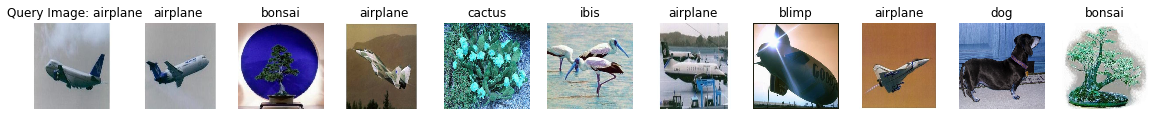

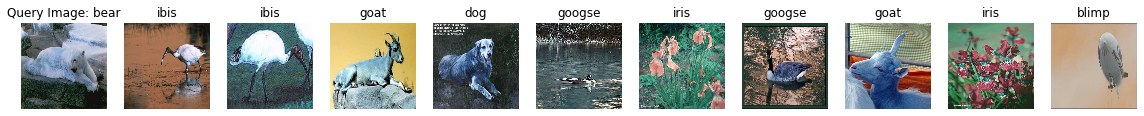

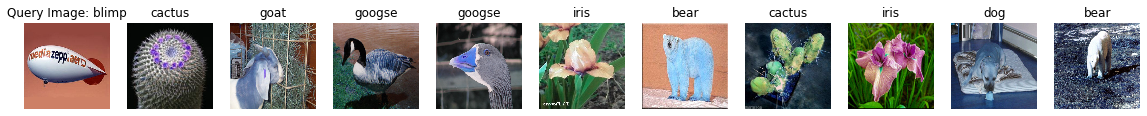

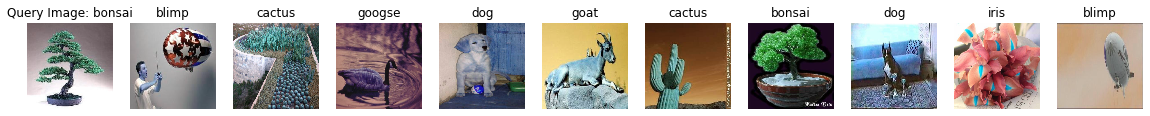

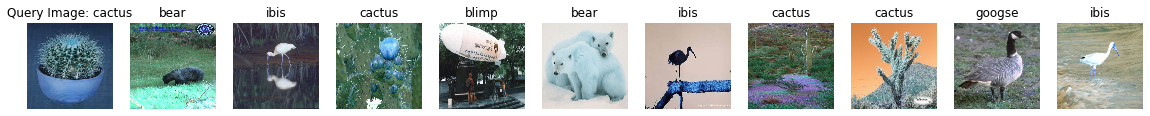

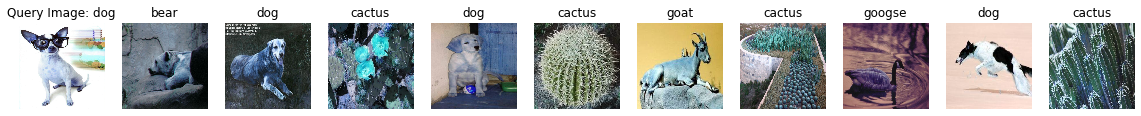

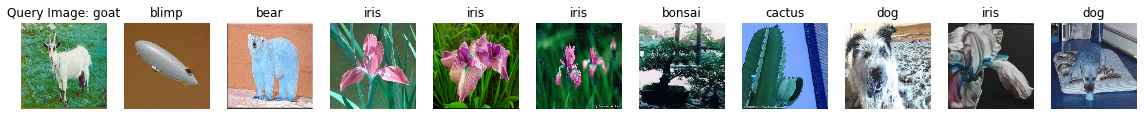

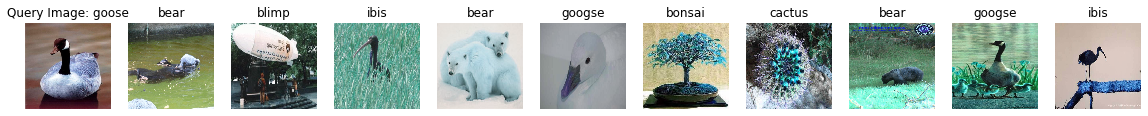

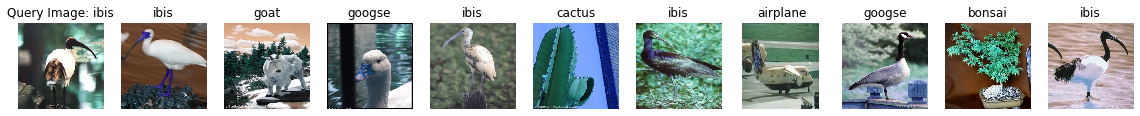

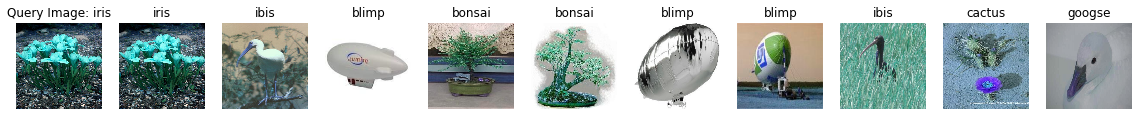

In [11]:
for i in range(0, 20, 2):
    number = i
    example = all_images[300+number]

    example_similars = [example]
    for j in similars[number]:
        example_similars.append(all_images[j])

    f, axes = plt.subplots(1, 11, figsize=(20, 20))
    #f.suptitle("Predictions", fontsize=20, y=0.65)

    for k, img in enumerate(axes.flat):
        img.imshow(example_similars[k])
        if k == 0:
            img.set_title("Query Image: " + categories[300+number])
        else:
            img.set_title(categories[similars[number][k-1]])
        img.axis('off')
    plt.show()